# Lifetime Customer Value Prediction
For the customers who registered between Jan and June 2016, predict their accumulative reputation (LCV) in the first 2 years based on their reputation score in first 6 months.
 * Reconstruct monthly reputation based on monthly activities: questions, answers, and accepted answers
 * Retain only first 24 months of data for each user
 * Construct regression models with MAE(Mean Absolute Error) as we care about the outliers
 
To do list:
 * Build a classifier for casual users and gold users < Define a cutoff threshold based on 80:20 rule >
 * Build a clustering model for gold users
 * Build a regressor for gold users

In [526]:
import pickle
import patsy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diagnostic_plots

from copy import deepcopy
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Prepare data for training

In [502]:
with open('./data/processed/lcv_2years.pkl', 'rb') as picklefile:
    lcv_2years = pickle.load(picklefile)
with open('./data/processed/user_basic.pkl', 'rb') as picklefile:
    user_basic = pickle.load(picklefile)
with open('./data/processed/lcv_answer_2years.pkl', 'rb') as picklefile:
    lcv_answer_2years = pickle.load(picklefile)
with open('./data/processed/lcv_question_2years.pkl', 'rb') as picklefile:
    lcv_question_2years = pickle.load(picklefile)

In [503]:
user_basic.set_index('id', inplace=True)
users = pd.merge(user_basic, lcv_2years, how='right', left_index=True, right_index=True)
y = pd.DataFrame(users.iloc[:,-24:].sum(axis=1), columns=['LCV'])
X = users.iloc[:, :-18]
X.drop(['last_access_year', 'last_access_month', 'up_votes', 'down_votes'], axis=1, inplace=True)

In [504]:
X.rename(columns={'M':'rep_M', 'M+1':'rep_M+1',
                 'M+2':'rep_M+2', 'M+3':'rep_M+3',
                 'M+4':'rep_M+4', 'M+5':'rep_M+5'}, inplace=True)

In [505]:
X = pd.merge(X, lcv_answer_2years.iloc[:,:6], how='left', left_index=True, right_index=True)
X.rename(columns={'M':'ans_M', 'M+1':'ans_M+1',
                 'M+2':'ans_M+2', 'M+3':'ans_M+3',
                 'M+4':'ans_M+4', 'M+5':'ans_M+5'}, inplace=True)

In [507]:
X = pd.merge(X, lcv_question_2years.iloc[:,:6], how='left', left_index=True, right_index=True)
X.rename(columns={'M':'qns_M', 'M+1':'qns_M+1',
                 'M+2':'qns_M+2', 'M+3':'qns_M+3',
                 'M+4':'qns_M+4', 'M+5':'qns_M+5'}, inplace=True)

In [508]:
def classifyHomepage(df_to_transform):
    df = deepcopy(df_to_transform)
    website_count = pd.DataFrame(df.website_url.value_counts())
    website_count.reset_index(inplace=True)
    personal_website = set(website_count[website_count['website_url']==1]['index'].values)
    df['personal_website'] = df['website_url'].apply(lambda x:1 if x in personal_website else 0)
    df.drop('website_url', axis=1, inplace=True)
    return df
X = classifyHomepage(X)

### Dummify the locations

In [509]:
with open('./data/processed/location_dict.pkl', 'rb') as picklefile:
    location_dict = pickle.load(picklefile)
def map_dummify_Locations(inputDF, location_dict):
    df = deepcopy(inputDF)
    df['location'] = df.location.apply(lambda x:location_dict[x] if x in set(location_dict.keys()) else 'Others')
    location_dummy = patsy.dmatrix('location', data=df, return_type='dataframe')
    df = pd.concat([df, location_dummy], axis = 1)
    df.drop('location', axis=1, inplace=True)
    new_colnames = [item.replace('[','-') for item in list(df.columns)]
    new_colnames = [item.replace(']','') for item in new_colnames]
    df.columns = new_colnames
    df.drop('Intercept', axis=1, inplace=True)
    return df

In [510]:
X_dummified = map_dummify_Locations(X, location_dict)

## EDA

In [513]:
y[y<0]=0
y.sort_values('LCV',inplace=False, ascending=False)[0:100]

LCV
id               
5741205  116080.0
6451573   99605.0
5928186   58280.0
5768908   52865.0
6433023   52275.0
6419007   48620.0
6361531   45495.0
6348498   42640.0
6464308   41655.0
6344363   36025.0
6294072   34285.0
6400526   29325.0
6336479   27460.0
6022656   27345.0
6535336   27095.0
5921745   26470.0
6231153   25315.0
6139861   22740.0
6067741   22130.0
5862071   20280.0
6428638   20230.0
5743988   20020.0
6163022   19835.0
5836671   19575.0
6143482   19360.0
6235047   19350.0
6521116   19225.0
6167855   19090.0
6287308   18870.0
5772882   18670.0
...           ...
5802115   11350.0
6053654   11195.0
5924562   11080.0
5827215   11070.0
6441124   10925.0
6296561   10865.0
6105720   10680.0
6343685   10560.0
6162307   10505.0
6507689   10425.0
6246044   10375.0
5894241   10255.0
6378815   10165.0
5749570    9945.0
6505250    9855.0
6040777    9815.0
6219979    9690.0
5965986    9545.0
6498658    9535.0
6136634    9445.0
6293409    9265.0
5892849    8990.0
6152400    8905.0
6525260    8845.0
5896501    8740.0
5867572    8720.0
6436398    8595.0
6529537    8545.0
6275103    8540.0
6309601    8415.0

[100 rows x 1 columns]

In [514]:
keep_index = (y.values < 30000) & (y.values > 0)

In [515]:
y = y[keep_index]
X_dummified = X_dummified[keep_index]

## Train-test split

In [516]:
X_train, X_test, y_train, y_test = train_test_split(X_dummified, y.values, test_size=0.2, random_state=4444)

## Observe the value we predict

In [487]:
def drawSectionPercentileBar(col_data, min_percentile, max_percentile):
    plt.figure(dpi=100)
    plt.plot(range(min_percentile, max_percentile+1), np.percentile(col_data, range(min_percentile, max_percentile+1)))
    plt.xticks(rotation=90)
    plt.xlabel('Percentile')
    plt.ylabel('Value')
    plt.yscale('log')
    plt.show()

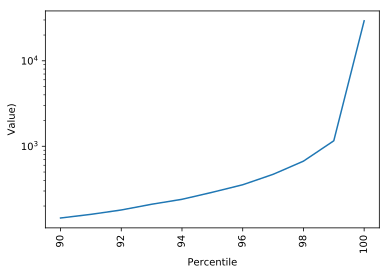

In [488]:
drawSectionPercentileBar(y_train, 90, 100)

## Perform classification task

In [ ]:
# Map the y value into 0(reputation<25) and 1(reputation>25)
def mapRepToCat(reputation):
    category = deepcopy(reputation)
    category[category<=np.log(25)]=0
    category[category>np.log(25)]=1
    return category
y_train_cat = mapRepToCat(y_train_log)
y_test_cat = mapRepToCat(y_test_log)

In [547]:
ten_perc_samplec_sample = np.random.choice(y_train_cat.shape[0], int(X_train.shape[0]*0.1))
X_train_sub = X_train.values[ten_perc_sample]
y_train_sub = y_train_cat[ten_perc_sample]

In [544]:
def gridSearchClassification(X, y):
    models = [
        #('knn', KNN),
        ('logistic', LogisticRegression),
        ('tree', DecisionTreeClassifier),
        ('forest', RandomForestClassifier),
        ('xgboost', XGBClassifier)
    ]

    param_choices = [
        {
            'n_neighbors': range(2,12)
        },
        {
            'C': np.logspace(-3,6,12),
            'penalty':['l1', 'l2']
        },
        {
            'max_depth': [2,3,4,5],
            'min_samples_leaf': [3,6,10]
        },
        {
            'n_estimators': [50,100,200],
            'max_depth': [1,2,3,4,5],
            'min_samples_leaf': [3,6,10]
        },
        {
            'max_depth': [3,4,5],
            'n_estimators': [1, 50, 100,200],
            'objective':['binary:logistic']
        }
    ]


    grids = {}
    for model_info, params in zip(models, param_choices):
        name, model = model_info
        grid = RandomizedSearchCV(model(), params, scoring='roc_auc', cv=5, n_jobs=-1)
        grid.fit(X, y)
        s = "{}: best score: {}".format(name, grid.best_score_)
        print(s)
        grids[name] = grid
    return grids

In [548]:
%time class_grids = gridSearchClassification(X_train_sub, y_train_sub.ravel())

logistic: best score: 0.800592549390961
tree: best score: 0.8316355692703474
forest: best score: 0.875556963230417
xgboost: best score: 0.8951161023816017
CPU times: user 5.82 s, sys: 2.34 s, total: 8.17 s
Wall time: 17.2 s


In [549]:
# Check if more data would help

def drawLearningCurve(model, X, y, ylim_lower = -100, ylim_higher = 100, save=False):
    best_clas_fit = model.fit(X, y)
    train_sizes, train_scores, test_scores = learning_curve(best_clas_fit, X, y, cv=5)
    ave_train_scores = train_scores.mean(axis=1)
    ave_test_scores = test_scores.mean(axis=1)

    learn_df  = pd.DataFrame({
        'train_size': train_sizes,
        'train_score': ave_train_scores,
        'test_score': ave_test_scores
    })

    plot_lm_0 = plt.figure(1)
    plot_lm_0.set_figheight(6)
    plot_lm_0.set_figwidth(12)
    plt.plot(learn_df['train_size'], learn_df['train_score'], 'r--o', label='train scores')
    plt.plot(learn_df['train_size'], learn_df['test_score'], 'b--x', label='test scores')
    plt.legend(loc='lower right', fontsize=20)
    plt.xlabel('Training sizes', fontsize=20)
    plt.ylabel('Score', fontsize=20)
    plt.title('Learning Curve', fontsize=26)
    plt.ylim(ylim_lower,ylim_higher)
    if (save):
        plt.save('./data/img/learning_curve.png')

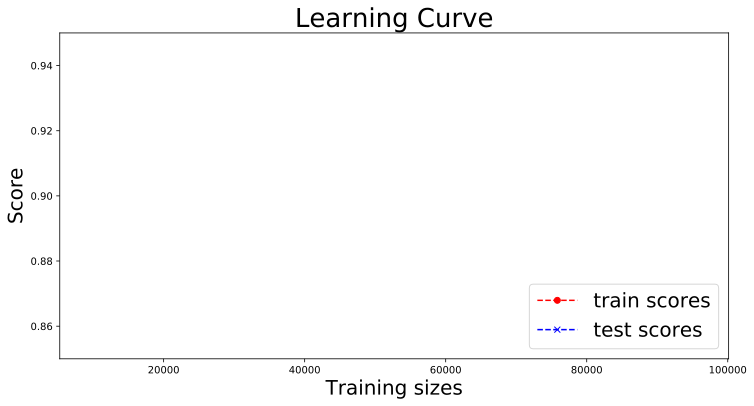

In [552]:
drawLearningCurve(class_grids['xgboost'].best_estimator_, X_train, y_train_cat.ravel(), .85, .95)

In [212]:
with open('./data/model/reputation_clas_grids.pkl', 'wb') as picklefile:
    pickle.dump(class_grids, picklefile)

## Check where the prediction performs well and bad

In [554]:
y_train_cat_pred = class_grids['xgboost'].best_estimator_.predict(X_train)

In [555]:
confusion_matrix(y_train_cat, y_train_cat_pred, labels=[0, 1])

array([[70720,  3596],
       [15820, 29634]])

In [556]:
FNindex = [ind for ind, value in enumerate(zip((y_train_cat == 1), (y_train_cat_pred == 0))) 
           if value == (True,True)]

In [557]:
print (f'Users who have positive reputations but predicted as zero have a median reputation of {np.mean(y_train[FNindex])}')

Users who have positive reputations but predicted as zero have a median reputation of 116.34165613147914


In [558]:
print (f'Users who have positive reputations have a median reputation of {np.mean(y_train[y_train>0])}') 

Users who have positive reputations have a median reputation of 86.92953160223762


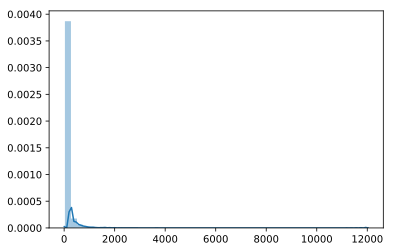

In [559]:
sns.distplot(y_train[FNindex], bins=50)

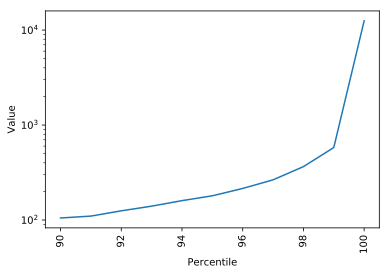

In [275]:
drawSectionPercentileBar(y_train[FNindex], 90, 100)

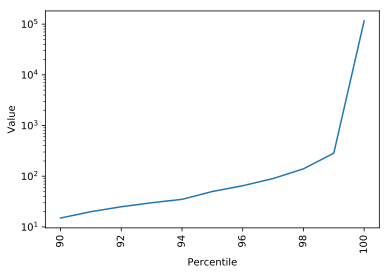

In [276]:
drawSectionPercentileBar(y_train, 90, 100)

In [282]:
## model predicts high values not so well, let's check why
# Retrieve values higher than 80% percentile that model predicts wrongly
high_wrong = [ind for ind, value in enumerate(zip((y_train_cat == 1), (y_train_cat_pred == 0), (y_train > 105))) 
           if value == (True,True,True)]
X_high_wrong = X_train.iloc[high_wrong,:]

In [292]:
X_high_wrong['six_month_reputation'] = X_high_wrong.iloc[:,4:10].sum(axis=1)
np.sum(X_high_wrong['six_month_reputation'] > 0)/X_high_wrong.shape[0]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0.0008016032064128256

### So the model has trouble predicting user reputations who have not earned any positive reputation in the first 6 months, but earned reputation later in the 2 year period. Which is understandable.

## Combine classification prediction probability with X_train

In [299]:
test = np.concatenate((X_train, class_grids['xgboost'].best_estimator_.predict_proba(X_train)[:,1]),axis=1)

In [563]:
(class_grids['xgboost'].best_estimator_.predict_proba(X_train)[:,1])[]

(119770,)

In [308]:
best_clas_fit.predict_proba(X_train_under)[:,1] > 0.5

array([False, False, False, ..., False,  True,  True])

In [309]:
best_clas_fit.predict_proba(X_train.values)[:,1]

array([0.9913413 , 0.15195476, 0.15035495, ..., 0.15035495, 0.15195476,
       0.15195476], dtype=float32)

In [310]:
X_train

about_me_length  creation_year  creation_month  profile_image     M  \
id                                                                             
6001826                0           2016               3              0   5.0   
6032966                0           2016               3              0   0.0   
5858688                0           2016               1              0   0.0   
6438600                0           2016               6              0   0.0   
5913012                0           2016               2              0   0.0   
6212084                0           2016               4              0   0.0   
5885603                0           2016               2              0   0.0   
6405178                0           2016               5              0   0.0   
6022228                0           2016               3              0   0.0   
6173476                0           2016               4              0   0.0   
5876539                0           2016               2              0   0.0   
5888843                0           2016               2              1  35.0   
5764619                0           2016               1              0   0.0   
6350476                0           2016               5              0   0.0   
6236890                0           2016               4              0   0.0   
6264212                0           2016               4              0   0.0   
6244812                0           2016               4              0   0.0   
5975568                0           2016               2              0   0.0   
6364512                0           2016               5              0   0.0   
6303124                0           2016               5              0   0.0   
6263328                0           2016               4              0   0.0   
5967076                0           2016               2              0   0.0   
5773575                0           2016               1              0   0.0   
5968195                0           2016               2              0   0.0   
6172679                0           2016               4              0   0.0   
6517335                0           2016               6              0   0.0   
6457970                0           2016               6              0   0.0   
5954799                0           2016               2              0   0.0   
6026023                0           2016               3              1  10.0   
6216297                0           2016               4              0   0.0   
...                  ...            ...             ...            ...   ...   
6100218                0           2016               3              0   0.0   
6235959                0           2016               4              0   0.0   
6221791                0           2016               4              0   0.0   
6512899                0           2016               6              0   0.0   
6056389                0           2016               3              0   0.0   
5925185                0           2016               2              0   0.0   
6431071                0           2016               6              0   0.0   
6122149                0           2016               3              0   0.0   
5869738                0           2016               2              0   0.0   
6078695                0           2016               3              0   0.0   
6155176                0           2016               4              0   0.0   
6214880                0           2016               4              0   0.0   
5828632                0           2016               1              0   0.0   
5960426                0           2016               2              0   0.0   
6195159                0           2016               4              0   0.0   
5775827                0           2016               1              0   0.0   
6002154              166           2016               3              0  -5.0   
6312714  

## Perform regression

In [433]:
# Convert negative y_value to 0 as SO doesn't allow reputation to go negative
#y_train[y_train<0]=0
#y_test[y_test<0]=0

# Sample 10% of data to speed training
#ten_perc_sample = np.random.choice(X_train.shape[0], int(X_train.shape[0]*0.1))
#X_train_sub = X_train.values[ten_perc_sample]
#y_train_sub = y_train[ten_perc_sample]

In [491]:
for n in np.linspace(5,100,20):
    print(f'{n}th percentile value is {np.percentile(y_train, n)}')

5.0th percentile value is 5.0
10.0th percentile value is 5.0
15.0th percentile value is 5.0
20.0th percentile value is 5.0
25.0th percentile value is 10.0
30.0th percentile value is 10.0
35.0th percentile value is 10.0
40.0th percentile value is 15.0
45.0th percentile value is 15.0
50.0th percentile value is 20.0
55.0th percentile value is 20.0
60.0th percentile value is 25.0
65.0th percentile value is 30.0
70.0th percentile value is 40.0
75.0th percentile value is 50.0
80.0th percentile value is 65.0
85.0th percentile value is 90.0
90.0th percentile value is 145.0
95.0th percentile value is 290.0
100.0th percentile value is 29325.0


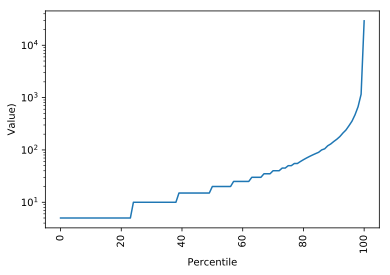

In [492]:
drawSectionPercentileBar(y_train, 0, 100)

In [517]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [518]:
def gridSearchSixModels(X, y):
    models = [
              ('Decision Tree', DecisionTreeRegressor),
              ('Random Forest', RandomForestRegressor),
              ('XGBoost', XGBRegressor)
             ]

    param_choices = [
        {
            'max_depth': [1,2,3,4,5],
            'min_samples_leaf': [3,6,10]
        },
        {
            'n_estimators': [50, 100, 200],
            'max_depth': [1,2,3,4,5],
            'min_samples_leaf': [3,6,10]
        },
        {
           'max_depth': [4,6,8],
           'n_estimators': [1,50,100,200],
           'objective':['reg:linear']
        }
    ]

    grids = {}
    #ftwo_scorer = make_scorer(fbeta_score, average='binary', beta=1.41)
    
    for model_info, params in zip(models, param_choices):
        print ('Now Fitting', model_info, '\n')
        name, model = model_info
        grid = RandomizedSearchCV(model(), params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
        grid.fit(X, y)
        s = "{}: best score: {}".format(name, grid.best_score_)
        print(s)
        grids[name] = grid
    return grids

Now Fitting ('Linear Regresion', <class 'sklearn.linear_model.base.LinearRegression'>) 

Linear Regresion: best score: -17.041738835689976
Now Fitting ('Decision Tree', <class 'sklearn.tree.tree.DecisionTreeRegressor'>) 

Decision Tree: best score: -24.31715897518711
Now Fitting ('Random Forest', <class 'sklearn.ensemble.forest.RandomForestRegressor'>) 

Random Forest: best score: -22.053882501982766
Now Fitting ('Gradient Boosted Trees', <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>) 

In [519]:
%time regres_grids = gridSearchSixModels(X_train, y_train_log.ravel())

Now Fitting ('Decision Tree', <class 'sklearn.tree.tree.DecisionTreeRegressor'>) 

Decision Tree: best score: -0.7297193346988525
Now Fitting ('Random Forest', <class 'sklearn.ensemble.forest.RandomForestRegressor'>) 

Random Forest: best score: -0.7091681771534663
Now Fitting ('XGBoost', <class 'xgboost.sklearn.XGBRegressor'>) 

XGBoost: best score: -0.5437417044231332
CPU times: user 31.3 s, sys: 1.75 s, total: 33.1 s
Wall time: 1min 57s


In [573]:
y_train_pred = regres_grids['XGBoost'].best_estimator_.predict(X_train)
five_precent_sample = np.random.choice(y_train.shape[0], int(y_train.shape[0]*0.05))
y_train_five_perc = y_train_log[five_precent_sample]
y_train_pred_five_perc = y_train_pred[five_precent_sample]

In [579]:
y_train_five_perc.shape

(5988, 1)

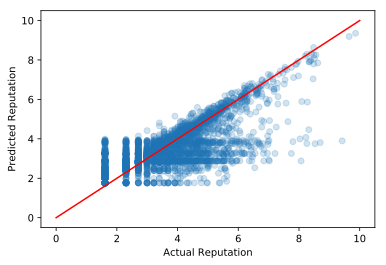

In [521]:
plt.scatter(y_train_five_perc, y_train_pred_five_perc, alpha=.2)
plt.plot([0,10],[0,10], 'r-')
plt.xlabel('Actual Reputation')
plt.ylabel('Predicted Reputation')
plt.show()

Text(0,0.5,'Residuals')

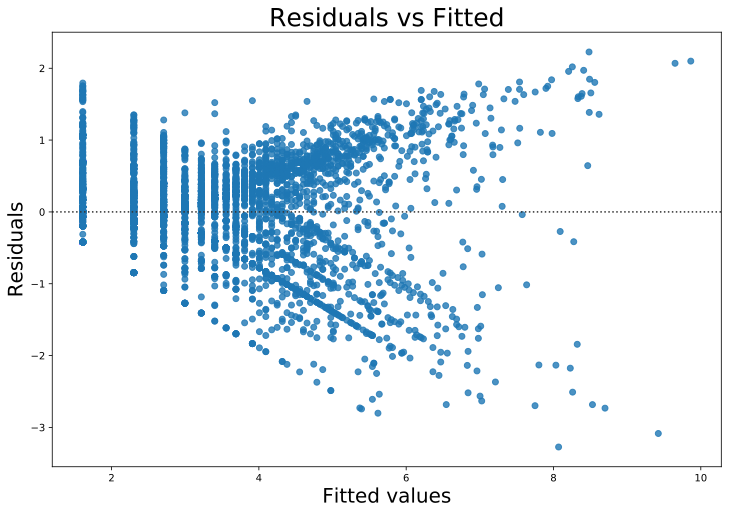

In [522]:
# Plot the residual plot
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)
sns.residplot(y_train_five_perc, y_train_pred_five_perc, 
              lowess=False, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.2})
plot_lm_1.axes[0].set_title('Residuals vs Fitted', fontsize=25)
plot_lm_1.axes[0].set_xlabel('Fitted values', fontsize=20)
plot_lm_1.axes[0].set_ylabel('Residuals',  fontsize=20)

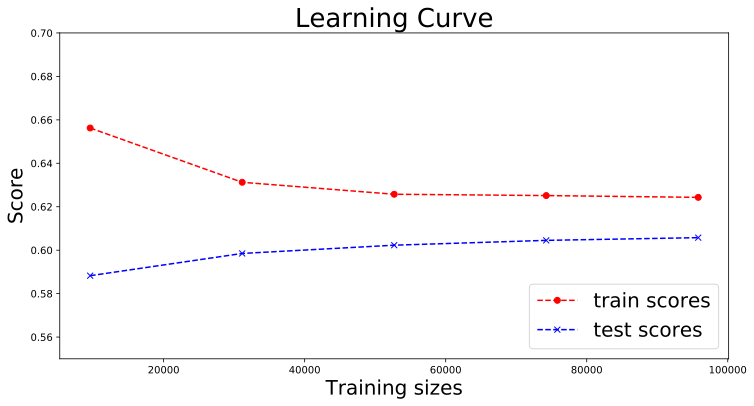

In [525]:
drawLearningCurve(regres_grids['XGBoost'].best_estimator_, X_train, y_train_log, 0.55, 0.7)

## How about adding classification result to X_train?

In [565]:
X_train_with_class = np.concatenate((X_train.values, class_grids['xgboost'].best_estimator_.predict_proba(X_train)[:,1][:,np.newaxis]),axis=1)

In [570]:
%time regres_class_grids = gridSearchSixModels(X_train_with_class, y_train_log.ravel())

Now Fitting ('Decision Tree', <class 'sklearn.tree.tree.DecisionTreeRegressor'>) 

Decision Tree: best score: -0.5791262040720789
Now Fitting ('Random Forest', <class 'sklearn.ensemble.forest.RandomForestRegressor'>) 

Random Forest: best score: -0.5710491265737065
Now Fitting ('XGBoost', <class 'xgboost.sklearn.XGBRegressor'>) 

XGBoost: best score: -0.5329677476332475
CPU times: user 35.7 s, sys: 1.78 s, total: 37.5 s
Wall time: 3min 16s


In [580]:
five_precent_sample.shape

(5988,)

In [581]:
y_class_train_pred = regres_class_grids['XGBoost'].best_estimator_.predict(X_train_with_class)
y_class_train_pred_five_perc = y_class_train_pred[five_precent_sample]

In [577]:
y_class_train_pred.shape

(611979,)

In [582]:
y_class_train_pred_five_perc.shape

(5988,)

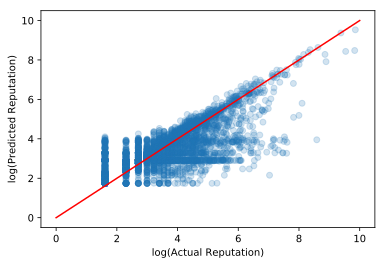

In [584]:
plt.scatter(y_train_five_perc, y_class_train_pred_five_perc, alpha=.2)
plt.plot([0,10],[0,10], 'r-')
plt.xlabel('log(Actual Reputation)')
plt.ylabel('log(Predicted Reputation)')
plt.show()

Text(0,0.5,'Residuals')

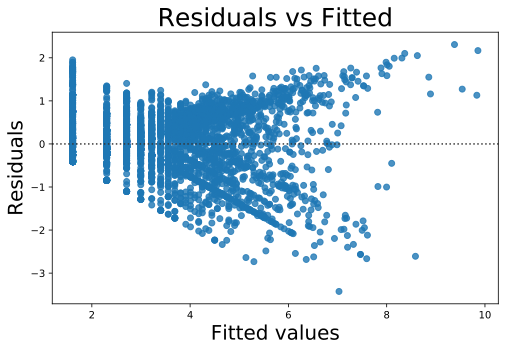

In [585]:
# Plot the residual plot
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(8)
sns.residplot(y_train_five_perc, y_class_train_pred_five_perc, 
              lowess=False, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted', fontsize=25)
plot_lm_1.axes[0].set_xlabel('Fitted values', fontsize=20)
plot_lm_1.axes[0].set_ylabel('Residuals',  fontsize=20)

In [588]:
lfit = LinearRegression().fit(X_train,y_train_log)

In [590]:
np.mean(np.absolute(y_train_log - lfit.predict(X_train)))

0.8984279706732797